#  Прогнозирование заказов такси



>[Прогнозирование заказов такси](#scrollTo=4E8CHbo3ut6O)

>>>[Описание проекта](#scrollTo=toofkiwpu4fw)

>>>[Описание данных](#scrollTo=5x2kRdwRvCkn)

>>[Подготовка](#scrollTo=jOugMH4qut6O)

>>>[1.1. Импорт библиотек](#scrollTo=7HSQcqZnvRh_)

>>>[1.2. Загрузка и первичный осмотр данных](#scrollTo=-tMLxqhlut6R)

>>>[1.3. Предобработка](#scrollTo=bJwn8iOXvcd3)

>>>[1.4. Ресемплирование](#scrollTo=NHq0pQb4vgN-)

>>>[Вывод по шагу 1](#scrollTo=AnW2kw6Dut6S)

>>[Анализ](#scrollTo=wzYBLLJ9vqZn)

>>>[Вывод по шагу 2](#scrollTo=4ne6owz9wMT_)

>>[Добавление новых признаков](#scrollTo=IAIEVcsUv3_-)

>>>[Вывод по шагу 3](#scrollTo=gztuYxL0ut6Z)

>>[Обучение моделей](#scrollTo=o5ub0EHmut6Z)

>>>[Вывод по шагу 4](#scrollTo=_NdLOb7Fut6b)

>>[Тестирование лучшей модели](#scrollTo=8sJxo-bUut6b)

>>>[Вывод по шагу 5](#scrollTo=X_3q4hK3ut6c)

>>[Итоговые выводы](#scrollTo=mlgEB6Rhy5cN)



### Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.





### Описание данных
Данные лежат в файле `taxi.csv`.


|Название столбца|Содержащиеся данные|
|-:|-:|
|`datetime`|дата и время|
|`num_orders`|количество заказов|

## 1. Подготовка



### 1.1. Импорт библиотек

In [ ]:
! pip install numpy==1.23.0 -q
! pip install matplotlib==3.7.3 -q
! pip install -U scikit-learn -q
! pip install optuna -q
! pip install optuna-integration[sklearn] -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler)
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
    TimeSeriesSplit)
from optuna.integration import OptunaSearchCV
from optuna.distributions import (FloatDistribution, IntDistribution)
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42

### 1.2. Загрузка и первичный осмотр данных

In [ ]:
taxi = pd.read_csv('/datasets/taxi.csv')
display(taxi.head())
taxi.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Данные загружены, корректно отображаются, соответствуют описанию, не содержат пропусков.

В ходе предобработки приведем столбец  `datetime` к соответствующему типу данных, проверим наличие дубликатов. Кроме того, проверим, за какой период имеются данные.



### 1.3. Предобработка

In [ ]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [ ]:
print('Количество дубликатов:', taxi['datetime'].duplicated().sum())
start = taxi['datetime'].min()
end = taxi['datetime'].max()
print(f'Данные за период: от {start} до {end}')

Количество дубликатов: 0
Данные за период: от 2018-03-01 00:00:00 до 2018-08-31 23:50:00


Теперь все типы данных соответствуют ожиданиям. Дубликатов не обнаружили. Имеются данные только за весну и лето 2018 года.

Ресемплируем данные по одному часу и сформируем новые признаки.


### 1.4. Ресемплирование

In [ ]:
taxi = taxi.set_index('datetime')
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
display(taxi.head())
taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Ресемплирование выполнено успешно.

### Вывод по шагу 1

Имеются данные только за весну и лето 2018 года.
Ресемплировали данные по одному часу.



## 2. Анализ

Рассмотрим графики тренда и сезонных колебаний, скользящего среднего.

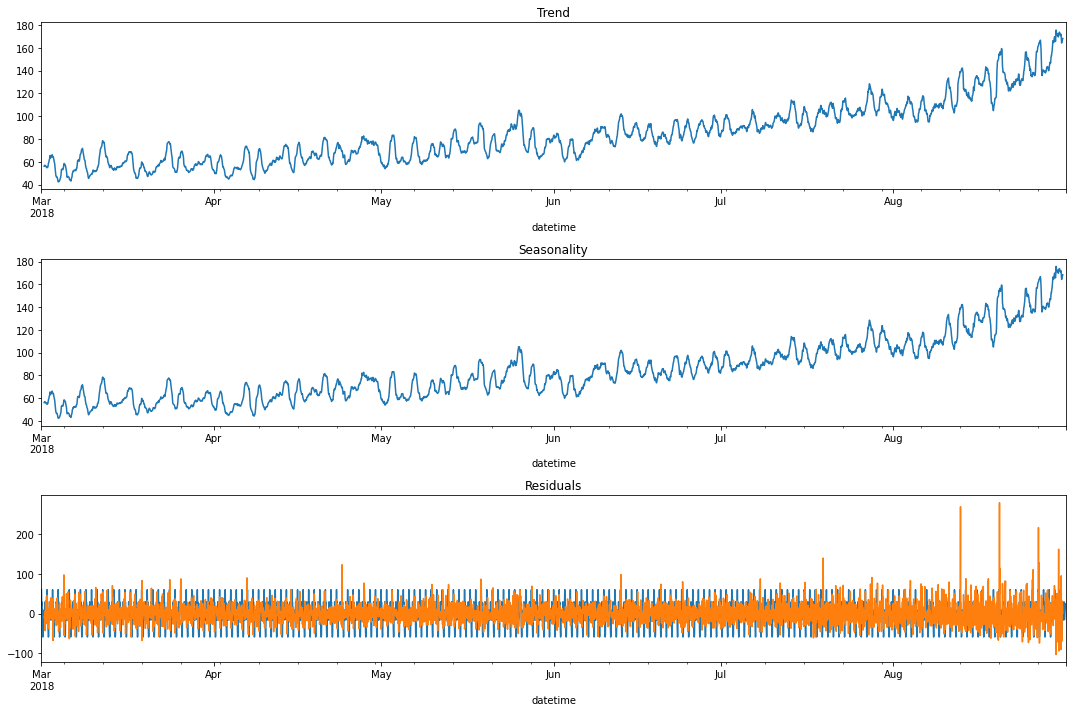

In [ ]:
decomposed = seasonal_decompose(taxi['num_orders'])

plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Residuals')
decomposed.resid.plot(ax=plt.gca())
plt.tight_layout()

В данных наблюдается тренд к увеличению, сезонность. Временной ряд нестационарный.
Рассмотрим сезонность на меньшем промежутке времени.

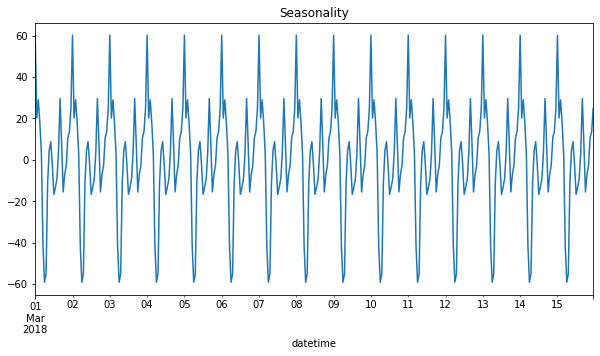

In [ ]:
plt.figure(figsize=(10, 5))
decomposed.seasonal['01-03-2018':'15-03-2018'].plot()
plt.title('Seasonality')
plt.show()

Наблюдается суточная сезонность. Рассмотрим ее на еще меньшем временном промежутке.

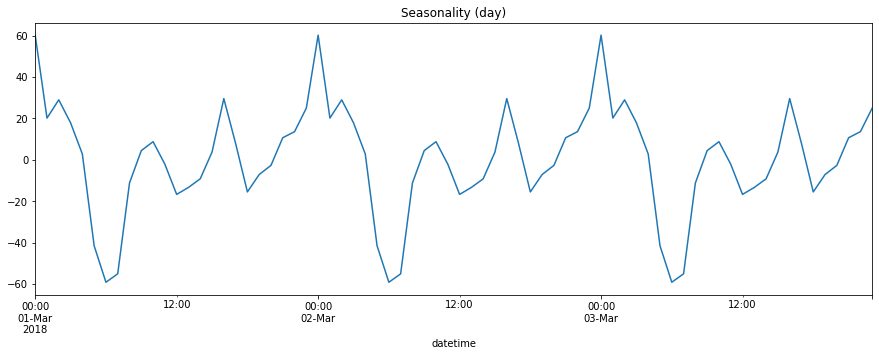

In [ ]:
plt.figure(figsize=(15, 5))
decomposed.seasonal['01-03-2018':'03-03-2018'].plot()
plt.title('Seasonality (day)')
plt.show()

В течение суток есть три отчетливых пика заказов:
- около полуночи;
- незадолго до полудня (примерно в 10 часов утра);
- приблизительно в 15-16 часов.
Кроме того, в сутках есть 2 небольших снижения (около 12 и 18 часов) и единственное резкое падение около 6 часов.

Ресемплируем данные по дню и посмотрим, есть ли недельная сезонность.

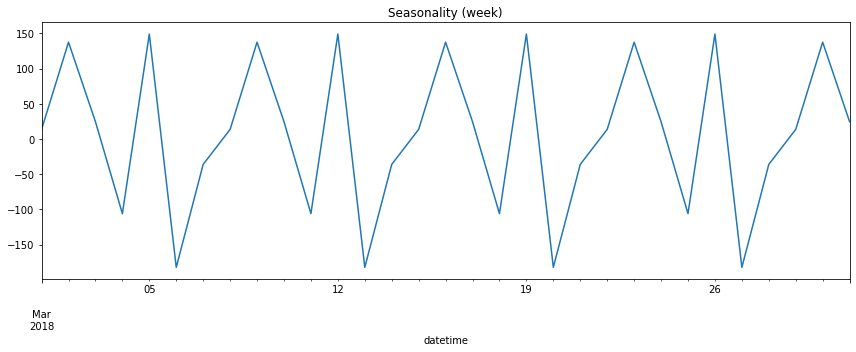

In [ ]:
resampled_day = taxi.resample('1D').sum()
decomposed_day = seasonal_decompose(resampled_day['num_orders'])

plt.figure(figsize=(12, 5))
plt.title('Seasonality (week)')
decomposed_day.seasonal['01-03-2018':'31-03-2018'].plot()
plt.tight_layout()

Заметна недельная сезонность: заказов больше в понедельник, пятницу и воскресенье, меньше - во вторник и субботу.

Следует добавить к входным признакам час и день недели.

А также скользящее среднее. Для скользящего среднего построим график. Перед обучением моделей сместим значения, чтобы избежать утечки данных.

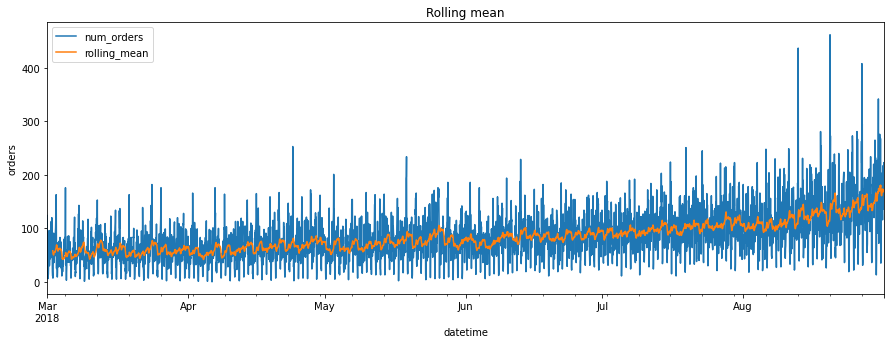

In [ ]:
taxi['rolling_mean'] = taxi['num_orders'].rolling(30, closed='left').mean()

plt.figure(figsize=(15, 5))
plt.title('Rolling mean')

taxi['num_orders'].plot()
taxi['rolling_mean'].plot()

plt.ylabel('orders')
plt.gca().legend()
plt.show()

Заметны выбросы, особенно значительные ближе к концу временного ряда. Прослеживается тренд к увеличению.

Изучим графики автокорреляции.

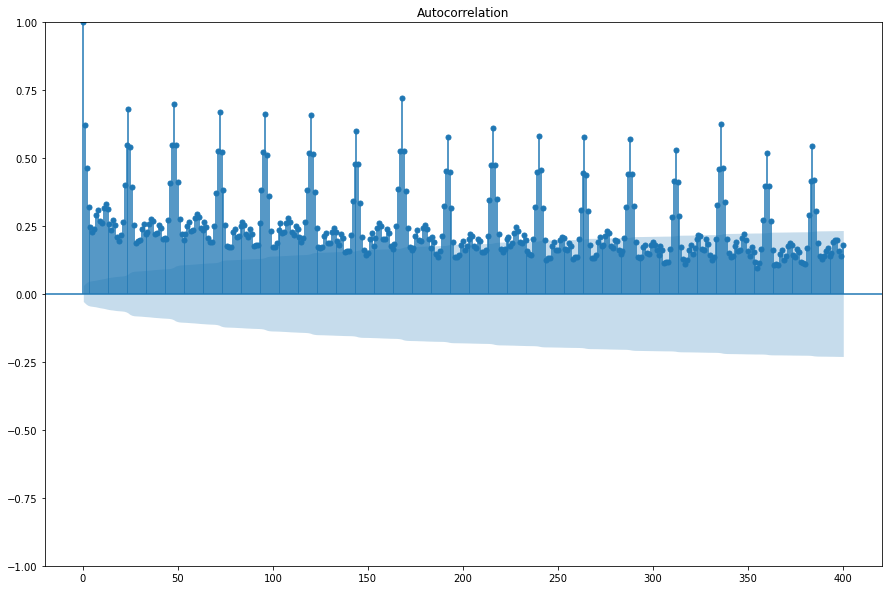

In [ ]:
fig, axes = plt.subplots(figsize=(15, 10))
plot_acf(taxi['num_orders'], lags=400, ax=axes)
plt.show()

Присутствуют регулярные повышения корреляции. Однако в 95-процентный доверительный интервал они не попадают. Тем не менее, ими можно воспользоваться, они должны быть обусловлены сезонностью. Рассмотрим аналогичный график в меньшем масштабе.

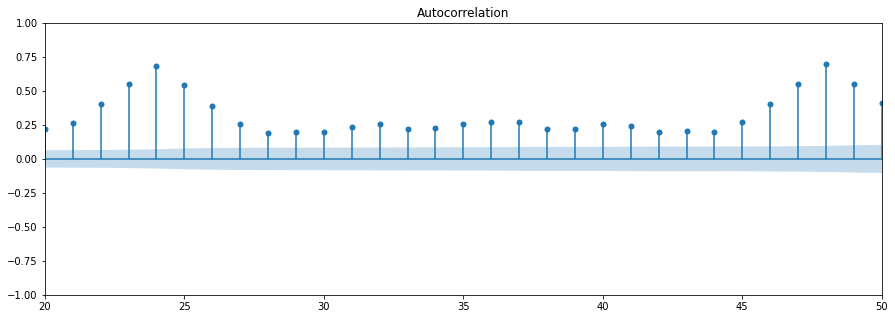

In [ ]:
fig, axes = plt.subplots(figsize=(15, 5))
plot_acf(taxi['num_orders'], lags=400, ax=axes)
axes.set_xlim([20, 50])
plt.show()

Сильная корреляция с данными за тот же час в предыдущие дни (на графике пики с промежутком 24).

Рассмотрим корреляцию с данными за тот же час в соответствующий день недели.

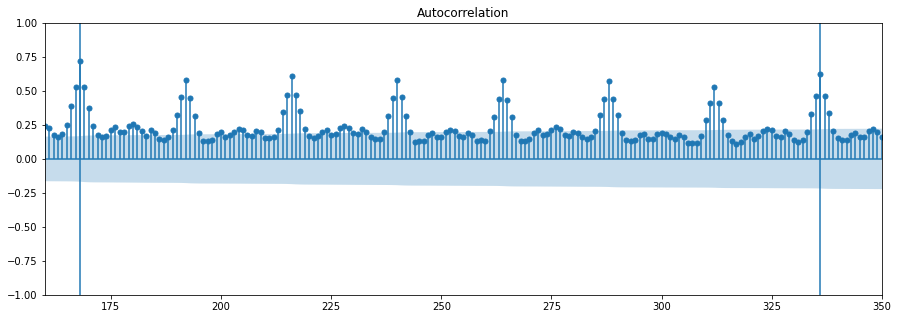

In [ ]:
fig, axes = plt.subplots(figsize=(15, 5))
plot_acf(taxi['num_orders'], lags=400, ax=axes)
axes.axvline(x=24*7*2)
axes.axvline(x=24*7)
axes.set_xlim([160, 350])
plt.show()

Действительно, наиболее высокие пики корреляции относятся к тем же часам в те же дни недели.

Стоит добавить к входным признакам отстающие значения с лагами 24 и 168.



### Вывод по шагу 2

Временной ряд нестационарный. В данных наблюдается тренд к увеличению, суточная сезонность.

В течение суток есть три отчетливых пика заказов:
- около полуночи;
- незадолго до полудня (примерно в 10 часов утра);
- приблизительно в 15-16 часов.
Кроме того, в сутках есть 3 снижения:
- около 12;
- около 18 часов;
- резкое падение около 6 часов.

Заметна недельная сезонность:
- заказов больше в понедельник, пятницу и воскресенье;
- меньше - во вторник и субботу.

Графики автокорреляции демонстрируют сильную взаимосвязь количества заказов в определенный час с количеством заказов в тот же час день назад и неделю назад.

## 3. Добавление новых признаков

Анализ показал, что для предсказания количества заказов в определенный час должны быть полезны следующие признаки:
- день недели;
- час;
- предыдущие значения временного ряда с лагами 24 и 168;
- смещенное скользящее среднее.

Добавим их в датасет и удалим строки, в которых образовались пропущенные значения.

In [ ]:
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour

taxi['lag_24'] = taxi['num_orders'].shift(24)
taxi['lag_168'] = taxi['num_orders'].shift(168)
taxi['rolling_mean_lag'] = taxi['rolling_mean'].shift(1)

taxi = taxi.dropna()
display(taxi.head())
taxi.info()

,num_orders,rolling_mean,dayofweek,hour,lag_24,lag_168,rolling_mean_lag
datetime,,,,,,,
2018-03-08 00:00:00,143,60.300000,3,0,100.0,124.0,58.900000
2018-03-08 01:00:00,78,63.366667,3,1,121.0,85.0,60.300000
2018-03-08 02:00:00,65,64.366667,3,2,24.0,71.0,63.366667
2018-03-08 03:00:00,68,63.766667,3,3,66.0,66.0,64.366667
2018-03-08 04:00:00,60,64.100000,3,4,73.0,43.0,63.766667


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   num_orders        4248 non-null   int64  
 1   rolling_mean      4248 non-null   float64
 2   dayofweek         4248 non-null   int64  
 3   hour              4248 non-null   int64  
 4   lag_24            4248 non-null   float64
 5   lag_168           4248 non-null   float64
 6   rolling_mean_lag  4248 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 265.5 KB


Добавление признаков прошло корректно.

### Вывод по шагу 3

На основании результатов анализа добавили новые признаки:
1. Календарные признаки:
- день недели;
- час.
2. Предыдущие значения временного ряда с лагами 24 и 168.
3. Скользящее среднее.

## 4. Обучение моделей
Разделим данные на тренировочную и тестовую выборки в соотношении 9:1.

Напишем пайплайн для масштабирования данных и обучения моделей:
- `SVR`;
- `LinearRegression`;
- `DecisionTreeRegressor`.

Выберем лучшую модель и ее гиперпараметры при помощи `RandomizedSearchCV()`, поскольку вариантов довольно много.

In [ ]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

X_train = train.drop(['num_orders', 'rolling_mean'], axis=1)
y_train = train['num_orders']

X_test = test.drop(['num_orders', 'rolling_mean'], axis=1)
y_test = test['num_orders']

In [ ]:
taxi.columns

Index(['num_orders', 'rolling_mean', 'dayofweek', 'hour', 'lag_24', 'lag_168',
       'rolling_mean_lag'],
      dtype='object')

In [ ]:
scale_cols = ['lag_24',
              'lag_168',
              'rolling_mean_lag']
scaler = ColumnTransformer(
    [
        ('num', StandardScaler(), scale_cols)
    ],
    remainder='passthrough'
)

In [ ]:
pipe_final = Pipeline(
    [('preprocessor', scaler),
     ('models', LinearRegression())]
)

params = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_leaf': range(2, 5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [SVR()],
        'models__kernel': ['rbf', 'linear'],
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    },
    {
        'models': [LGBMRegressor()],
        'models__learning_rate': [1e-8, 0.001, 0.01, 0.05, 0.1, 0.3],
        'models__n_estimators': [100, 500, 1000],
        'models__max_depth': [5, 10, 20],
        'models__subsample': [1e-8, 0.001, 0.01, 0.05, 0.1],
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    }
]

In [ ]:
search = RandomizedSearchCV(
        pipe_final,
        params,
        cv=TimeSeriesSplit(n_splits=3),
        scoring='neg_root_mean_squared_error',
        n_iter=20,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['lag_24',
                                                                                'lag_168',
                                                                                'rolling_mean_lag'])])),
                                             ('models', LinearRegression())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions=[{'models': [LinearReg...
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LGBMRegressor()],
                                         'models__learning_rate': [1e-08, 0.001,
                                                                   0.01, 0.05,
                                                                   0.1, 0.3],
                                         'models__max_depth': [5, 10, 20],
                                         'models__n_estimators': [100, 500,
                                                                  1000],
                                         'models__subsample': [1e-08, 0.001,
                                                               0.01, 0.05,
                                                               0.1],
                                         'preprocessor__num': [StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
best_estimator = search.best_estimator_
print('Лучшая модель и ее параметры:\n', best_estimator)
print(search.best_params_)
print()
print ('Метрика RMSE лучшей модели на кроссвалидации:',
       search.best_score_ * -1)

Лучшая модель и ее параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['lag_24', 'lag_168',
                                                   'rolling_mean_lag'])])),
                ('models',
                 LGBMRegressor(learning_rate=0.05, max_depth=20,
                               subsample=0.001))])
{'preprocessor__num': 'passthrough', 'models__subsample': 0.001, 'models__n_estimators': 100, 'models__max_depth': 20, 'models__learning_rate': 0.05, 'models': LGBMRegressor()}

Метрика RMSE лучшей модели на кроссвалидации: 24.639294565582688


In [ ]:
results = pd.DataFrame(search.cv_results_)
display(results[['param_models',
                 'param_preprocessor__num',
                 'param_models__min_samples_leaf',
                 'param_models__max_depth',
                 'param_models__kernel',
                 'mean_test_score']].sort_values(by='mean_test_score'))

,param_models,param_preprocessor__num,param_models__min_samples_leaf,param_models__max_depth,param_models__kernel,mean_test_score
10,LGBMRegressor(),RobustScaler(),NaN,10.0,NaN,-42.670729
7,LGBMRegressor(),passthrough,NaN,5.0,NaN,-42.670628
13,LGBMRegressor(),StandardScaler(),NaN,5.0,NaN,-42.670501
16,LGBMRegressor(),StandardScaler(),NaN,10.0,NaN,-42.670495
2,LGBMRegressor(),StandardScaler(),NaN,5.0,NaN,-40.248129
6,LGBMRegressor(),passthrough,NaN,10.0,NaN,-33.161093
19,DecisionTreeRegressor(random_state=42),RobustScaler(),2.0,9.0,NaN,-31.315918
0,DecisionTreeRegressor(random_state=42),RobustScaler(),3.0,9.0,NaN,-29.603060
9,SVR(),passthrough,NaN,NaN,rbf,-29.264484
8,DecisionTreeRegressor(random_state=42),StandardScaler(),4.0,9.0,NaN,-28.685863


Лучшей моделью оказалась `LGBMRegressor` с гиперпараметрами:
`subsample` = 0.001, `n_estimators` = 100, `max_depth` = 20, `learning_rate` = 0.05.
Модели с меньшей максимальной глубиной демонстрировали худшие результаты.

Ее метрика *RMSE* = 24.639, что ощутимо меньше 48, следовательно, модель подходит для наших целей. Однако выбранные гиперпараметры `n_estimators` и `max_depth` приняли пограничные значения, следовательно, есть смысл сдвинуть границы и запустить подбор снова. Выполним это при помощи `OptunaSearchCV()`.

Кроме того, лучшая подготовка `passthrough` (и действительно, решающие деревья не требуют масштабирования данных), значит, в дальнейшем можно пропустить масштабирование.

In [ ]:
lgbm_params = {
    'subsample': FloatDistribution(low=0.01, high=0.1, step=0.01),
    'learning_rate': FloatDistribution(low=0.3, high=0.7, step=0.1),
    'n_estimators': IntDistribution(low=50, high=150, step=10),
    'max_depth': IntDistribution(low=18, high=26, step=2)
}

In [ ]:
opt_search = OptunaSearchCV(LGBMRegressor(),
                            param_distributions = lgbm_params,
                            cv=TimeSeriesSplit(n_splits=3),
                            max_iter=2000,
                            n_jobs=-1,
                            n_trials=10,
                            scoring='neg_root_mean_squared_error',
                            random_state=RANDOM_STATE)
opt_search.fit(X_train, y_train)

/tmp/ipykernel_32/1821212682.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  opt_search = OptunaSearchCV(LGBMRegressor(),
[I 2024-12-01 12:35:44,478] A new study created in memory with name: no-name-24ba4a41-7d14-4d60-9fc7-bca40e036e9a
[I 2024-12-01 12:36:08,487] Trial 0 finished with value: -26.450763462224007 and parameters: {'subsample': 0.04, 'learning_rate': 0.4, 'n_estimators': 60, 'max_depth': 22}. Best is trial 0 with value: -26.450763462224007.
[I 2024-12-01 12:36:08,581] Trial 2 finished with value: -27.226580296691065 and parameters: {'subsample': 0.04, 'learning_rate': 0.5, 'n_estimators': 60, 'max_depth': 22}. Best is trial 0 with value: -26.450763462224007.
[I 2024-12-01 12:36:09,075] Trial 5 finished with value: -26.37267458733613 and parameters: {'subsample': 0.01, 'learning_rate': 0.4, 'n_estimators': 60, 'max_depth': 18}. Best is trial 5 with value: -26.37267458733613.
[I 2024-12-01 12:36:12

OptunaSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
               estimator=LGBMRegressor(), max_iter=2000, n_jobs=-1,
               param_distributions={'learning_rate': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1),
                                    'max_depth': IntDistribution(high=26, log=False, low=18, step=2),
                                    'n_estimators': IntDistribution(high=150, log=False, low=50, step=10),
                                    'subsample': FloatDistribution(high=0.1, log=False, low=0.01, step=0.01)},
               random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
best_lgbm = opt_search.best_estimator_
print(best_lgbm)
print()
print(opt_search.best_params_)
print()
print ('Метрика RMSE лучшей LGBMRegressor на кроссвалидации:',
       opt_search.best_score_ * -1)

LGBMRegressor(learning_rate=0.3, max_depth=26, n_estimators=50, subsample=0.04)

{'subsample': 0.04, 'learning_rate': 0.3, 'n_estimators': 50, 'max_depth': 26}

Метрика RMSE лучшей LGBMRegressor на кроссвалидации: 25.65200560494687


Новый перебор гиперпараметров не дал улучшения метрики за 10 попыток. Вернемся к модели, показавшей лучшие результаты изначально.

### Вывод по шагу 4

Обучили три разные модели:
- `SVR`;
- `LinearRegression`;
- `DecisionTreeRegressor`.

При помощи `RandomizedSearchCV()` выявили, что лучшей моделью для решения нашей задачи является `LGBMRegressor`. Поскольку гиперпараметры, приведшие к наилучшему результату, оказались пограничными, расширили границы и выполнили дополнительный подбор гиперпараметров модели `LGBMRegressor` при помощи `OptunaSearchCV()`.

Получили значение *RMSE* чуть-чуть больше,чем при первом подборе. Поэтому будем считать лучшей моделью первую, выбранную при помощи `RandomizedSearchCV()`.



## 5. Тестирование лучшей модели
Проверим лучшую модель на тестовой выборке.

In [ ]:
y_test_pred = best_estimator.predict(X_test)
print('LGBMRegressor. Метрика RMSE на тестовой выборке:',
     np.sqrt(mean_squared_error(y_test, y_test_pred)))

LGBMRegressor. Метрика RMSE на тестовой выборке: 41.11008659637953


Метрика, полученная на тестовой выборке, меньше 48, следовательно, качество модели удовлетворительное.

Проанализируем важность признаков для модели, а также ее остатки.

,feature,importance
4,rolling_mean_lag,720
2,lag_24,697
0,dayofweek,611
1,hour,551
3,lag_168,421


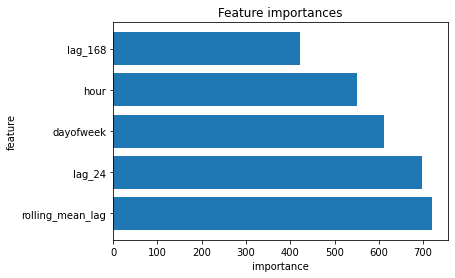

In [ ]:
feature_importances = pd.DataFrame([
    best_estimator.feature_names_in_,
    best_estimator[1].feature_importances_]).T
feature_importances.columns=(['feature',
                              'importance'])
feature_importances = feature_importances.sort_values(
    by='importance',
    ascending=False)
display(feature_importances)

plt.xlabel('importance')
plt.ylabel('feature')
plt.barh(y=feature_importances['feature'],
         width=feature_importances['importance'])
plt.title('Feature importances')
plt.show()

Наиболее важными признаками для модели стали смещенное скользящее среднее и количество заказов в тот же час сутки назад. С небольшим отрывом за ними следуют день недели и час. Еще несколько менее важным оказалось количество заказов в тот же час неделю назад.

При этом все входные признаки оказались значимыми.

Похоже, выявленные на этапе анализа суточные колебания оказывают больше влияния на количество заказов, чем прочие. Однако это заключение нужно делать осторожно, поскольку мы имеем дело с данными только весны и лета, зимой и осенью ситуация может выглядеть иначе.

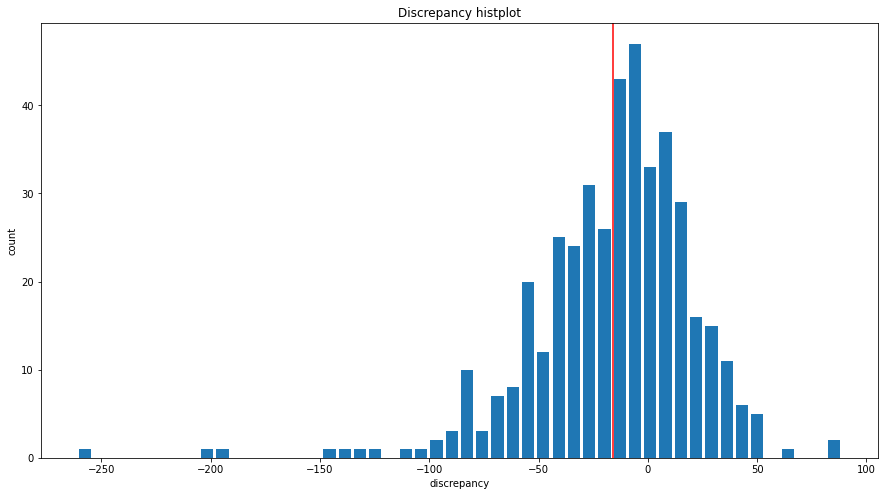

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Discrepancy histplot')
plt.xlabel('discrepancy')
plt.ylabel('count')

plt.hist(x=y_test_pred-y_test, bins=50, histtype='bar', rwidth=0.8)
plt.axvline(x=(y_test_pred-y_test).mean(), color='red')
plt.show()

Распределение остатков модели стремится к нормальному, однако левый склон более пологий, и вершина (а также среднее) смещена влево относительно нуля. Это говорит о том, что модель часто преуменьшает количество заказов.

Возможно, причина - тренд к увеличению, который более выражен ближе к концу имеющегося временного ряда.

### Вывод по шагу 5
Проверили выбранную модель на тестовой выборке, получили удовлетворительное значение метрики.

Проанализировали важность признаков и остатки модели. Заключили, что:
* в наибольшей степени при прогнозировании модель руководствуется часом (то есть суточные колебания оказывают наибольшее влияние);
* модель часто преуменьшает количество заказов (распределение остатков смещено влево).

## Итоговые выводы
1. В ходе предобработки:
* привели столбец  `datetime` к соответствующему типу данных;
* не обнаружили дубликатов;
* обнаружили, что данные есть только за весну и лето 2018 года;
* ресемплировали данные по одному часу;
2. Выполнили анализ данных при помощи визуализации, отметили:
* временной ряд нестационарный;
* наблюдается тренд к увеличению;
* суточная сезонность, есть три отчетливых пика заказов:
    * около полуночи;
    * незадолго до полудня (примерно в 10 часов утра);
    * приблизительно в 15-16 часов.
* в сутках есть 2 небольших снижения (около 12 и 18 часов) и единственное резкое падение около 6 часов.
3. На основании результатов анализа добавили новые признаки:
    3.1. Календарные признаки:
    * день недели;
    * час.
    3.2. Предыдущие значения временного ряда с лагами 24 и 168.
    3.3. Скользящее среднее.
4. В пайплайне выполнили обучение и кроссвалидацию моделей:
    
    4.1. Обучили три разные модели:
    * `SVR`;
    * `LinearRegression`;
    * `DecisionTreeRegressor`.
    4.2. При помощи `RandomizedSearchCV()` выявили, что лучшей моделью для решения нашей задачи является `LGBMRegressor`.
5. Проверили выбранную модель на тестовой выборке.
    
    5.1. Полученная метрика меньше 48, качество модели удовлетворительное.
    
    5.2. Проанализировали важность признаков для модели:
    * наиболее важными признаками для модели стали смещенное скользящее среднее и количество заказов в тот же час сутки назад;
    * с небольшим отрывом за ними следуют день недели и час;
    * еще несколько менее важным оказалось количество заказов в тот же час неделю назад.
       
    Похоже, выявленные на этапе анализа суточные колебания оказывают больше влияния на количество заказов, чем прочие. Однако это заключение нужно делать осторожно, поскольку мы имеем дело с данными только весны и лета, зимой и осенью ситуация может выглядеть иначе.
    
    5.3. Проанализировали распределение остатков модели. Оно стремится к нормальному, но левый склон более пологий, и вершина смещена влево относительно нуля. Это говорит о том, что модель часто преуменьшает количество заказов.
    Возможная причина - тренд к увеличению, который более выражен ближе к концу имеющегося временного ряда.